In [3]:
import os
import json
import numpy as np
import faiss
embedding_cache_path = '/mnt/data/data-selection/data/processed/sharegpt/embeddings.npy'
scores_path = '/mnt/data/data-selection/data/processed/sharegpt/scores.jsonl'

In [4]:
embeddings = np.load(embedding_cache_path)
scores = []
with open(scores_path) as f:
    for line in f:
        scores.append(json.loads(line))
embeddings.shape

(168864, 4096)

In [5]:
# perform k-means clustering with embeddings
K = 64
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

kmeans = faiss.Kmeans(d, K, niter=75, verbose=True, nredo=5, gpu=True)
kmeans.train(embeddings)

Sampling a subset of 16384 / 168864 for training
Clustering 16384 points in 4096D to 64 clusters, redo 5 times, 75 iterations
  Preprocessing in 0.84 s
Outer iteration 0 / 5
  Iteration 74 (4.49 s, search 4.12 s): objective=405289 imbalance=1.202 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 74 (9.09 s, search 8.25 s): objective=398585 imbalance=1.234 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 74 (13.60 s, search 12.37 s): objective=398043 imbalance=1.261 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 74 (17.99 s, search 16.31 s): objective=405467 imbalance=1.330 nsplit=0       
Outer iteration 4 / 5
  Iteration 74 (22.36 s, search 20.20 s): objective=399797 imbalance=1.256 nsplit=0       


398043.28125

In [12]:
distances, indices = kmeans.index.search(embeddings, 1)
K = 64
# flatten indices
indices = indices.reshape(-1)
eval_scores = [i['eval_score'] for i in scores]
cluster2score = {}
for i in range(K):
    i_cluster_indices = np.where(indices == i)[0]
    i_cluster_scores = [eval_scores[j] for j in i_cluster_indices]
    cluster2score[i] = i_cluster_scores

<Axes: title={'center': 'Distribution of eval scores for each cluster'}, xlabel='Cluster', ylabel='Eval score'>

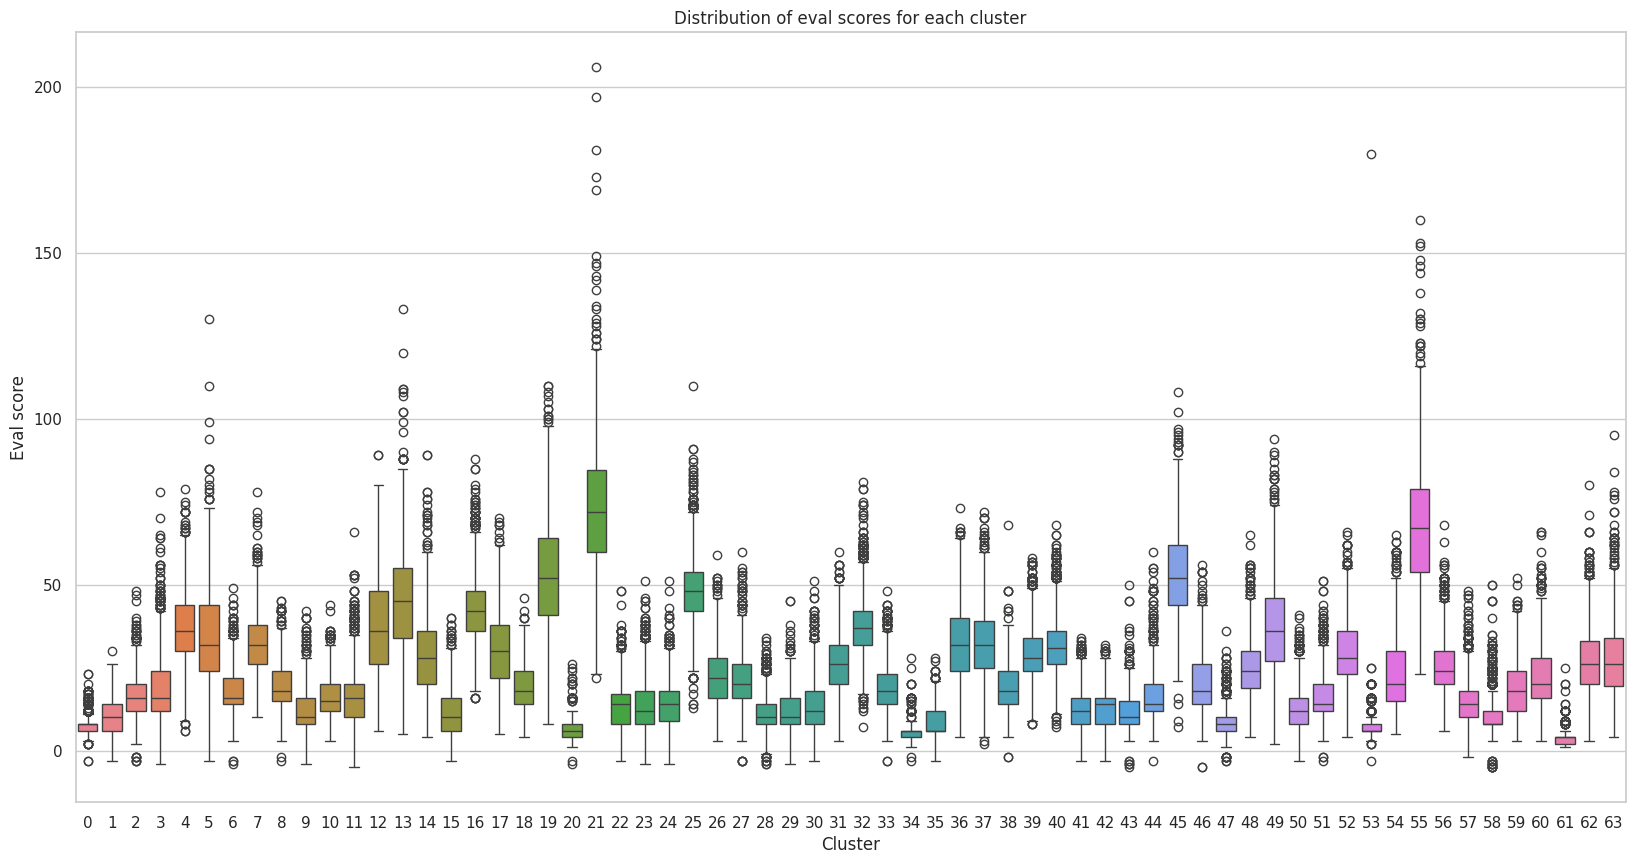

In [14]:
# plot the distribution of eval scores for each cluster
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Distribution of eval scores for each cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Eval score')
sns.boxplot(data=list(cluster2score.values()), ax=ax)